<a href="https://colab.research.google.com/github/Manas-Kumar-Muduli/Multilevel-Classification-of-Chest-X-Ray/blob/master/Multilevel_Classification_Of_Chest_X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import tensorflow as tf

**Connect to google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("/content/gdrive/MyDrive/archive/train")


Found 6326 files belonging to 4 classes.


In [ ]:
import tensorflow_datasets as tfds
batch_size=64
dataset_name=dataset
class_names=dataset.class_names
print(class_names)

['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


**Resize Dataset**

In [ ]:
size=(512, 512)
resize=dataset.map(lambda image, label:(tf.image.resize(image, size), label))

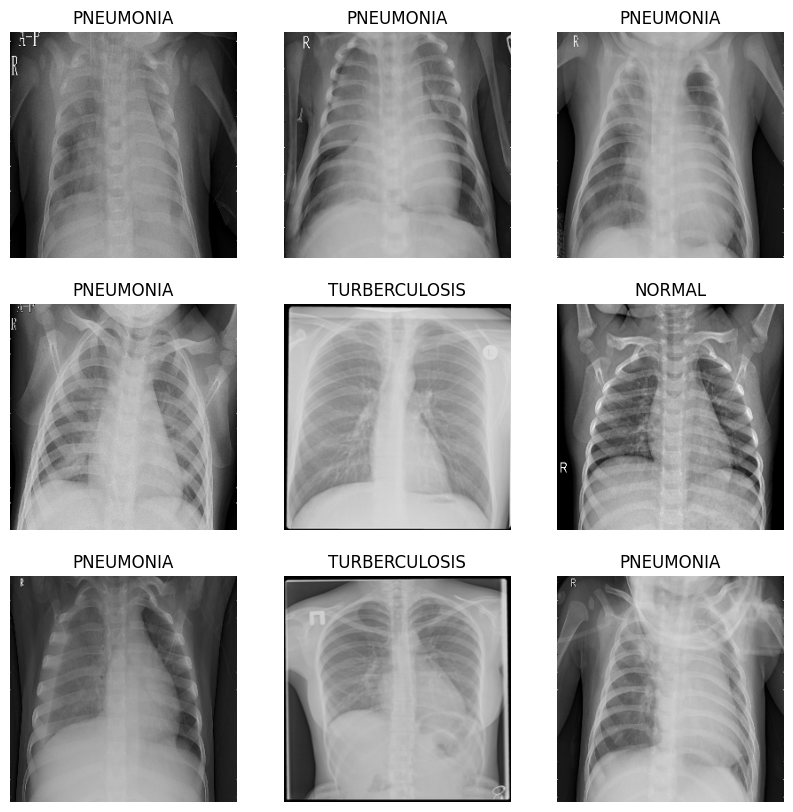

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Normalizeize Images**

In [ ]:
import cv2
import os

# Define the root directory where the images are located
root_dir = "/content/gdrive/MyDrive/archive/train"

# List all subdirectories (classes) in the root directory
class_dirs = os.listdir(root_dir)

# Create a directory to save the output normalized images
output_dir = 'output_normalized_images'
os.makedirs(output_dir, exist_ok=True)

# Loop through each class directory
for class_dir in class_dirs:
    class_path = os.path.join(root_dir, class_dir)

    # List all image files in the current class directory
    image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

    # Loop through each image in the class directory
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Error: Unable to load image '{image_path}'. Skipping...")
            continue

        # Normalize the image
        normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

        # Save the normalized image
        output_path = os.path.join(output_dir, class_dir, image_file)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cv2.imwrite(output_path, normalized_image)

print(f"Normalized images in {len(class_dirs)} classes. Output images saved in '{output_dir}' directory.")


Normalized images in 4 classes. Output images saved in 'output_normalized_images' directory.


**VGG16**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Define paths to your training and testing data directories
train_data_dir = "/content/gdrive/MyDrive/archive/train"
test_data_dir = "/content/gdrive/MyDrive/archive/test"
# Image dimensions
img_width, img_height = 128, 128
input_shape = (img_width, img_height, 3)

# Define hyperparameters
batch_size = 32
epochs = 10

# Create a VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(4 , activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Load and preprocess test data
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Train the model
model.fit(train_generator, epochs=epochs, validation_data=test_generator)



58889256/58889256 [==============================] - 3s 0us/step
Found 6326 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
Epoch 1/10
198/198 [==============================] - 3725s 19s/step - loss: 0.3947 - accuracy: 0.8568 - val_loss: 0.4693 - val_accuracy: 0.8314
Epoch 2/10
198/198 [==============================] - 1583s 8s/step - loss: 0.2510 - accuracy: 0.9091 - val_loss: 0.3858 - val_accuracy: 0.8508
Epoch 3/10
198/198 [==============================] - 1549s 8s/step - loss: 0.2165 - accuracy: 0.9187 - val_loss: 0.3123 - val_accuracy: 0.8898
Epoch 4/10
198/198 [==============================] - 1552s 8s/step - loss: 0.2007 - accuracy: 0.9278 - val_loss: 0.3643 - val_accuracy: 0.8742
Epoch 5/10
198/198 [==============================] - 1616s 8s/step - loss: 0.1902 - accuracy: 0.9301 - val_loss: 0.3840 - val_accuracy: 0.8833
Epoch 6/10
198/198 [==============================] - 1592s 8s/step - loss: 0.1919 - accuracy: 0.9282 - val_loss: 0.3452 - val_accu

**Accuracy**

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

# Calculate and print the accuracy in percentage
test_accuracy_percent = test_accuracy * 100

print(f"Test Accuracy: {test_accuracy_percent:.2f}%")

25/25 [==============================] - 169s 7s/step - loss: 0.3545 - accuracy: 0.8872
Test Accuracy: 88.72%


**F1-score**

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Predict the class labels for the test data
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get the true class labels
y_true = test_generator.classes

# Calculate the F1-score
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Weighted F1-score: {f1:.4f}')


25/25 [==============================] - 171s 7s/step
Weighted F1-score: 0.3700


**Precission**

In [ ]:
from sklearn.metrics import precision_score
import numpy as np

# Make predictions on the test data
y_pred = model.predict(test_generator)

# Convert one-hot encoded predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Calculate the precision for each class
precision = precision_score(y_true, y_pred_classes, average=None)

# Print the precision for each class
for class_index, class_precision in enumerate(precision):
    print(f'Precision for class {class_index}: {class_precision:.2f}')


25/25 [==============================] - 167s 7s/step
Precision for class 0: 0.16
Precision for class 1: 0.29
Precision for class 2: 0.52
Precision for class 3: 0.02


**Recall**

In [ ]:
from sklearn.metrics import recall_score

# Make predictions on the test data
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate recall
recall = recall_score(y_true, y_pred_classes, average='macro')

print(f"Recall: {recall:.2f}")


25/25 [==============================] - 198s 8s/step
Recall: 0.24


**Precision-Recall curve**

25/25 [==============================] - 165s 7s/step


<ipython-input-23-28b08a95502b>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


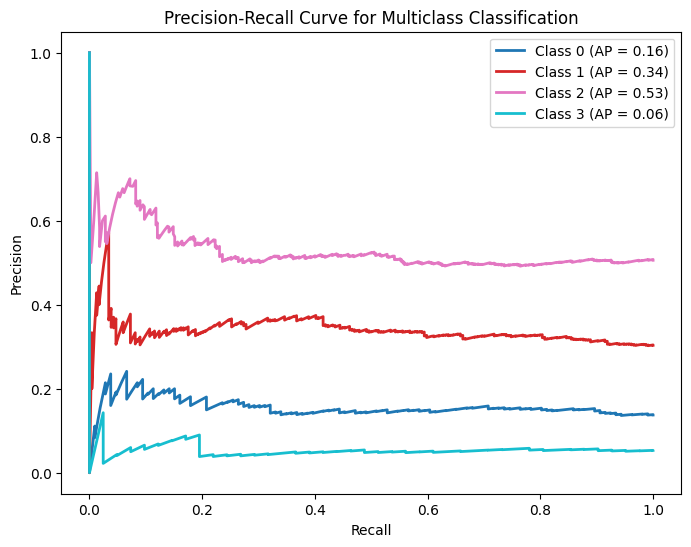

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Generate predictions on the test dataset
y_pred = model.predict(test_generator)

# Get true labels from the test generator
y_true = test_generator.classes

# Number of classes
num_classes = len(test_generator.class_indices)

# Initialize arrays to store precision, recall, and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_pred[:, i])

# Plot precision-recall curves for each class
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', num_classes)

for i, color in zip(range(num_classes), colors.colors):
   plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Class {i} (AP = {average_precision[i]:.2f})')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass Classification')
plt.legend(loc='best')
plt.show()


25/25 [==============================] - 168s 7s/step


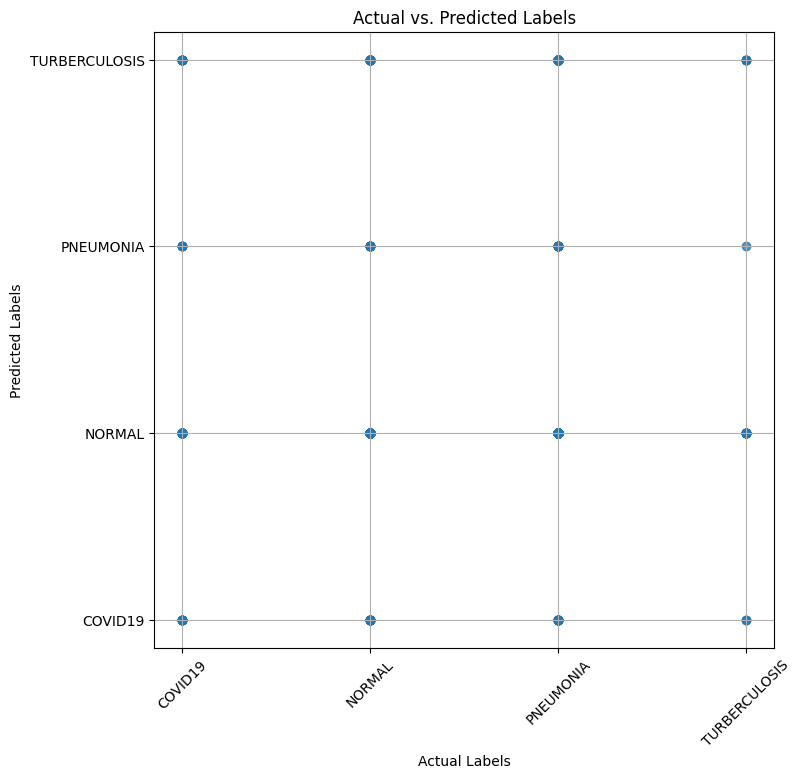

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate predictions for the test dataset
predictions = model.predict(test_generator)

# Get the actual class labels for the test data
actual_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Map class labels to their corresponding indices
label_to_index = {label: index for index, label in enumerate(class_labels)}

# Convert one-hot encoded predictions to class indices
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# Map predicted class indices back to class labels
predicted_labels = [class_labels[index] for index in predicted_labels]

# Create a scatter plot of actual vs. predicted labels
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, predicted_labels, alpha=0.5)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Actual vs. Predicted Labels')
plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.yticks(range(len(class_labels)), class_labels)
plt.grid(True)
plt.show()


**CNN**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the paths to your training and validation datasets
train_data_dir = "/content/gdrive/MyDrive/archive/train"  # Path to your training data
validation_data_dir = "/content/gdrive/MyDrive/archive/val"  # Path to your validation data

# Define hyperparameters
image_height, image_width = 128, 128
batch_size = 32
num_epochs = 10
num_classes = 4  # Number of classes in your dataset

# Create an ImageDataGenerator with data augmentation for the training set
train_data_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create an ImageDataGenerator for the validation set
validation_data_gen = ImageDataGenerator(rescale=1.0/255)

# Create CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Create data generators for training and validation
train_generator = train_data_gen.flow_from_directory(
    train_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_data_gen.flow_from_directory(
    validation_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model
history=model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator)

# Save the trained model
model.save('my_cnn_model.h5')


Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Epoch 1/10
198/198 [==============================] - 1159s 5s/step - loss: 0.9539 - accuracy: 0.6189 - val_loss: 1.1420 - val_accuracy: 0.4737
Epoch 2/10
198/198 [==============================] - 318s 2s/step - loss: 0.6815 - accuracy: 0.7128 - val_loss: 0.8823 - val_accuracy: 0.6842
Epoch 3/10
198/198 [==============================] - 336s 2s/step - loss: 0.6281 - accuracy: 0.7430 - val_loss: 0.7453 - val_accuracy: 0.6579
Epoch 4/10
198/198 [==============================] - 322s 2s/step - loss: 0.5781 - accuracy: 0.7702 - val_loss: 0.8979 - val_accuracy: 0.6842
Epoch 5/10
198/198 [==============================] - 329s 2s/step - loss: 0.5069 - accuracy: 0.8019 - val_loss: 0.5787 - val_accuracy: 0.7895
Epoch 6/10
198/198 [==============================] - 324s 2s/step - loss: 0.4850 - accuracy: 0.8158 - val_loss: 0.9100 - val_accuracy: 0.7105
Epoch 7/10
198/198 [==============================] - 307s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Accuracy & Loss Diagram**

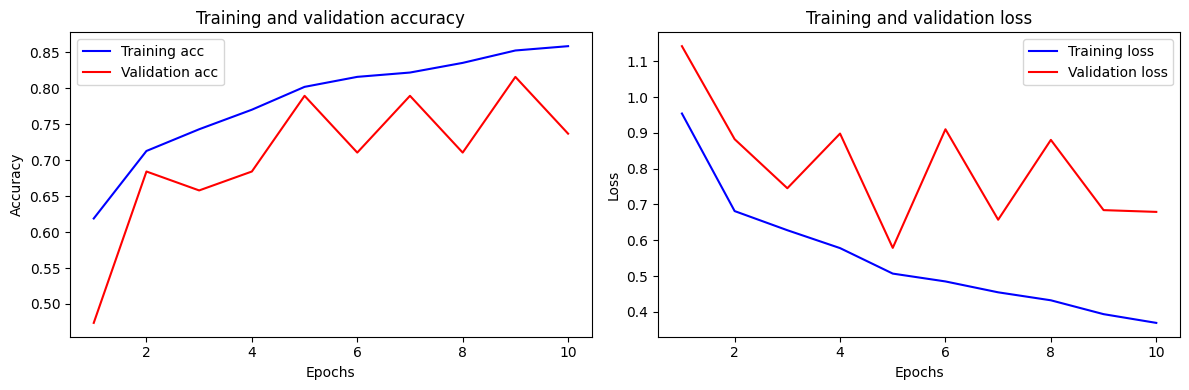

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


# Plot the training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


**Accuracy**

In [ ]:

# Extract accuracy values
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Get the final accuracy values
final_training_accuracy = training_accuracy[-1]
final_validation_accuracy = validation_accuracy[-1]

print(f"Final Training Accuracy: {final_training_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%")


Final Training Accuracy: 85.85%
Final Validation Accuracy: 73.68%


**F1-Score**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Evaluate the model on the validation set
validation_generator.reset()
predictions = model.predict(validation_generator, verbose=1)
predicted_classes = tf.argmax(predictions, axis=1)

# Convert one-hot encoded labels to categorical labels
true_classes = validation_generator.classes

# Calculate F1-score
f1 = f1_score(true_classes, predicted_classes, average='weighted')
print(f"F1-score: {f1}")


2/2 [==============================] - 1s 110ms/step
F1-score: 0.23927775011366342


**Precision**

In [ ]:
from sklearn.metrics import precision_score
import numpy as np

# Load the saved model
loaded_model = tf.keras.models.load_model('my_cnn_model.h5')

# Generate predictions for the validation set
validation_predictions = loaded_model.predict(validation_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(validation_predictions, axis=1)

# Get true labels
true_labels = validation_generator.classes

# Calculate precision
precision = precision_score(true_labels, predicted_classes, average='weighted')

print(f'Precision: {precision}')


2/2 [==============================] - 2s 49ms/step
Precision: 0.3661654135338346


**Recall**

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, recall_score

# Load the trained model
loaded_model = tf.keras.models.load_model('my_cnn_model.h5')

# Generate predictions on the validation set
validation_generator.reset()  # Reset the generator to the beginning of the validation set
y_pred = loaded_model.predict(validation_generator, steps=len(validation_generator), verbose=1)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = validation_generator.classes

# Calculate recall for each class
recall_per_class = recall_score(y_true, y_pred_classes, average=None)

# Display recall for each class
for i in range(num_classes):
    print(f'Recall for class {i}: {recall_per_class[i]}')

# Display overall classification report
print('\nClassification Report:\n', classification_report(y_true, y_pred_classes))


2/2 [==============================] - 2s 152ms/step
Recall for class 0: 0.1
Recall for class 1: 0.5
Recall for class 2: 0.375
Recall for class 3: 0.16666666666666666

Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.10      0.12        10
           1       0.80      0.50      0.62         8
           2       0.21      0.38      0.27         8
           3       0.17      0.17      0.17        12

    accuracy                           0.26        38
   macro avg       0.33      0.29      0.29        38
weighted avg       0.30      0.26      0.27        38

